In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
%load_ext cudf.pandas
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('XAUUSD_Hourly.csv')

df = df.drop(columns=['Spread','Volume'])

df.head()

,Date,Time,Open,High,Low,Close,TickVolume,datetime,Target_Close
0,2025.05.01,01:00:00,3289.25,3290.21,3271.43,3274.02,5132,2025-05-01 01:00:00,3272.69
1,2025.05.01,02:00:00,3274.28,3285.10,3269.83,3272.69,4855,2025-05-01 02:00:00,3246.51
2,2025.05.01,03:00:00,3273.13,3276.33,3241.21,3246.51,8490,2025-05-01 03:00:00,3238.92
3,2025.05.01,04:00:00,3246.51,3251.34,3234.38,3238.92,6694,2025-05-01 04:00:00,3241.58
4,2025.05.01,05:00:00,3238.95,3251.74,3235.17,3241.58,5156,2025-05-01 05:00:00,3229.51


In [3]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Date          298 non-null    object
 1   Time          298 non-null    object
 2   Open          298 non-null    float64
 3   High          298 non-null    float64
 4   Low           298 non-null    float64
 5   Close         298 non-null    float64
 6   TickVolume    298 non-null    int64
 7   datetime      298 non-null    object
 8   Target_Close  298 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 28.2+ KB


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.boxplot(x='Time', y='TickVolume', data=df)
plt.title('Box Plot of TickVolume and Time')
plt.xlabel('Time')
plt.ylabel('TickVolume')
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'seaborn'

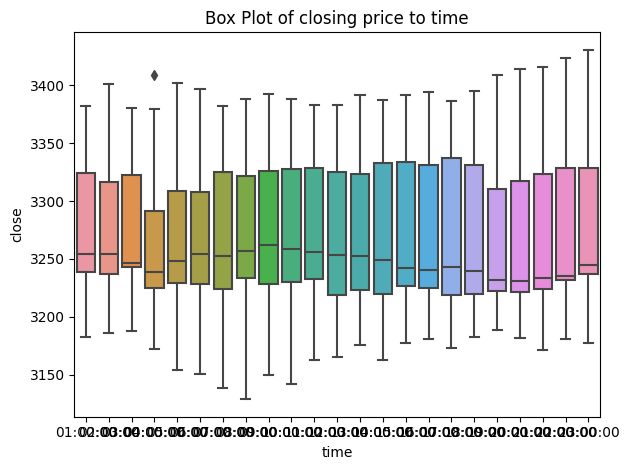

In [ ]:
plt.figure()
sns.boxplot(x='Time', y='Close', data=df)
plt.title('Box Plot of closing price to time')
plt.xlabel('time')
plt.ylabel('close')
plt.tight_layout()
plt.show()

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

In [ ]:
def add_lag(df):
    for lag in [1, 2, 3]:
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    return df

# Rolling averages (with shift to prevent leakage)
def rolling_avg(df):
    for window in [3, 4, 5]:
        df[f'roll_mean_{window}'] = df['Close'].shift(1).rolling(window=window).mean()
        df[f'roll_std_{window}'] = df['Close'].shift(1).rolling(window=window).std()
    return df

In [ ]:
df0 = df.copy()

df0 = add_lag(df0)
df0 = rolling_avg(df0)

df0.dropna(inplace=True)
df0.head()

,Date,Time,Open,High,Low,Close,TickVolume,datetime,Target_Close,hour,dayofweek,lag_1,lag_2,lag_3,roll_mean_3,roll_std_3,roll_mean_4,roll_std_4,roll_mean_6,roll_std_6
6,2025.05.01,07:00:00,3229.57,3231.98,3221.32,3226.63,5705,2025-05-01 07:00:00,3236.64,7,3,3229.51,3241.58,3238.92,3236.670000,6.341774,3239.1300,7.142721,3250.538333,18.524258
7,2025.05.01,08:00:00,3226.63,3238.83,3223.44,3236.64,6486,2025-05-01 08:00:00,3235.75,8,3,3226.63,3229.51,3241.58,3232.573333,7.931811,3234.1600,7.211967,3242.640000,16.502475
8,2025.05.01,09:00:00,3236.67,3243.19,3233.87,3235.75,7645,2025-05-01 09:00:00,3230.12,9,3,3236.64,3226.63,3229.51,3230.926667,5.153177,3233.5900,6.787994,3236.631667,7.457285
9,2025.05.01,10:00:00,3235.78,3236.96,3226.09,3230.12,6947,2025-05-01 10:00:00,3235.24,10,3,3235.75,3236.64,3226.63,3233.006667,5.540256,3232.1325,4.849704,3234.838333,5.691311
10,2025.05.01,11:00:00,3230.14,3236.76,3229.97,3235.24,5135,2025-05-01 11:00:00,3218.51,11,3,3230.12,3235.75,3236.64,3234.170000,3.535520,3232.2850,4.748280,3233.371667,5.561494


In [ ]:
df0 = df.drop(columns = ['Date','Time','datetime'])

X_lag = df0.drop(columns = ['Target_Close'])
y_lag = df0['Target_Close']

In [ ]:
%load_ext cuml.accel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


X_lag_train,X_lag_test,y_lag_train,y_lag_test = train_test_split(X_lag,y_lag,random_state=42)

[2025-06-09 19:01:45.929] [CUML] [info] cuML: Installed accelerator for sklearn.


2025-06-09 19:02:00.216226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749495720.404747      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749495720.460094      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[2025-06-09 19:02:17.454] [CUML] [info] cuML: Installed accelerator for umap.
[2025-06-09 19:02:17.502] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-06-09 19:02:17.502] [CUML] [info] cuML: Successfully initialized accelerator.


In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_lag_train,y_lag_train)

RandomForestRegressor()

In [ ]:
rf_preds = rf_model.predict(X_lag_test)

print(f"MAE: {mean_absolute_error(y_lag_test, rf_preds)}")
print(f"R² score on test data: {r2_score(y_lag_test, rf_preds)}")

MAE: 7.638874918518401
R² score on test data: 0.9761088511817476


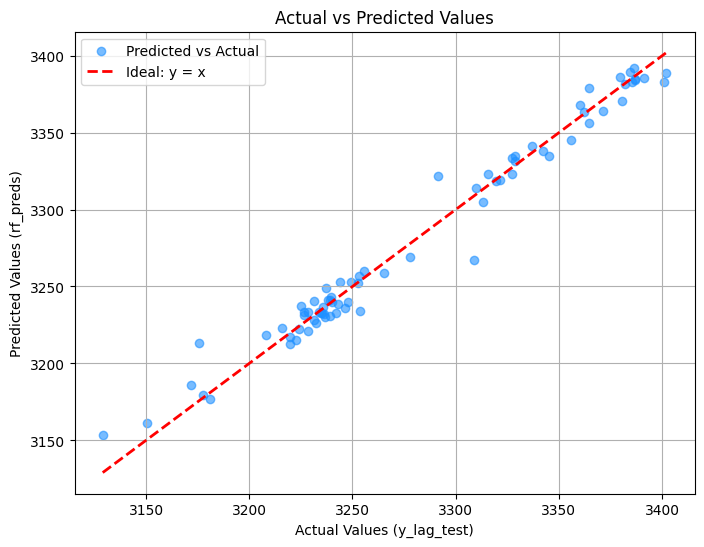

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_lag_test, rf_preds, alpha=0.6, color='dodgerblue', label='Predicted vs Actual')
plt.plot([y_lag_test.min(), y_lag_test.max()], [y_lag_test.min(), y_lag_test.max()], 'r--', lw=2, label='Ideal: y = x')

plt.xlabel("Actual Values (y_lag_test)")
plt.ylabel("Predicted Values (rf_preds)")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(device='cuda',tree_method='hist')

xgb_model.fit(X_lag_train,y_lag_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_preds = xgb_model.predict(X_lag_test)

print(f"MAE: {mean_absolute_error(y_lag_test, xgb_preds)}")
print(f"R² score on test data: {r2_score(y_lag_test, xgb_preds)}")

MAE: 9.93071236979166
R² score on test data: 0.9653308709742245


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:02:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


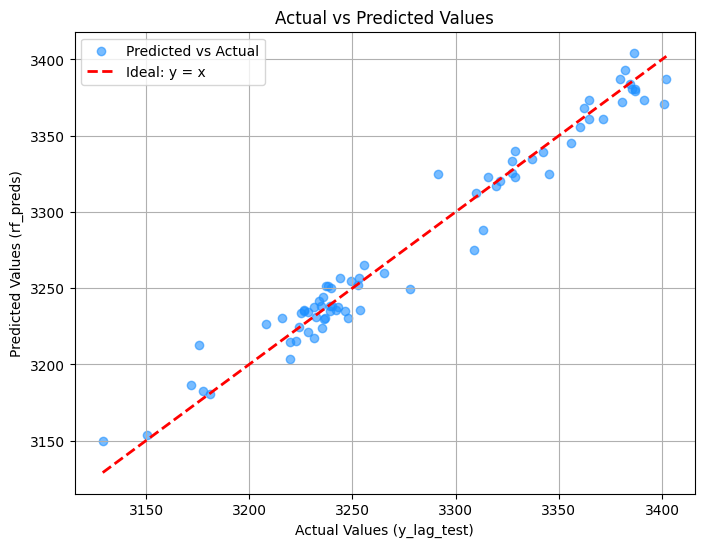

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_lag_test, xgb_preds, alpha=0.6, color='dodgerblue', label='Predicted vs Actual')
plt.plot([y_lag_test.min(), y_lag_test.max()], [y_lag_test.min(), y_lag_test.max()], 'r--', lw=2, label='Ideal: y = x')

plt.xlabel("Actual Values (y_lag_test)")
plt.ylabel("Predicted Values (rf_preds)")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib

model_params = rf_model.get_params()
joblib.dump(model_params, 'model_params.pkl')

['model_params.pkl']

In [ ]:
model = RandomForestRegressor(**joblib.load('model_params.pkl'))
model.fit(X_lag_train, y_lag_train)  

[2025-06-09 19:02:19.935] [CUML] [info] Unused keyword parameter: ccp_alpha during cuML estimator initialization


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)


RandomForestRegressor()